# Ruuvi Fridge
This is my first project to collect data with Ruuvi tag from my refrigerator and use that data to machine learning models.

### Data
Temperature and humidity over night in my fridge. Blue lines mark where the fridge's motor starts and stops. Red line is when fridge door is opened.
![Image](tmp/ruuvi-fridge/graph1.png "Data")

Motor starts (blue line)
* Temperature decreases
* Humidity decreases

Motor stops (blue line)
* Temperature and humidity starts to raise

Fridge door opens
* Sudden jump in humidity and temperature


Fridge door opened. Notice rapid raise of humidity and temperature
![Image](tmp/ruuvi-fridge/Screenshot_2019-11-01%20Ruuvi%20tagit%20-%20door_open.png "Door open")

### Predicting temperature using Tensor Flow and Recurrent Neural Network(RNN)
Predicting temperature in fridge when door is closed is easy but lets see how RNN can handle when fridge door is opened

#### Import libraries

In [21]:
import tensorflow as tf
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
import plotly.offline as py
import matplotlib.pyplot as plt

#### Load data

In [22]:
# Data files
csv_path1 = "data/ruuvi_20191025.csv"
csv_path2 = "data/ruuvi_20191026.csv"
csv_path3 = "data/ruuvi_20191027.csv"
csv_path4 = "data/ruuvi_20191028.csv"

# Load files
df1 = pd.read_csv(csv_path1)
df2 = pd.read_csv(csv_path2)
df3 = pd.read_csv(csv_path3)
df4 = pd.read_csv(csv_path4)

#### Prepare data
Combine data to one data frame

In the dataset are samples less than second intervals. We don't need so many data points. Lets resample points to average of 20 second steps.

In [24]:
# Combine datasets
df = pd.concat([df1,df2,df3,df4])

# Filter by tag address
tag2_address = 'e7:99:d1:af:26:34'
df = df[df.address == tag2_address]

# Convert (strange from InfluxDB) unix time to date object
df['date'] = pd.to_datetime(df['time'] / 1000000000,unit='s')
df.index = pd.to_datetime(df.date)


# Combine acceleration absolute values to new feature
df['movement'] = df['accelerationX'].abs() + df['accelerationY'].abs() + df['accelerationZ'].abs()

# Remove unused columns
features_considered = ['temperature', 'humidity', 'movement']
df = df[features_considered]

# Downsample
df = df.resample('20S').mean() 

#### Plot unscaled data
You can notice variation of temperature and movement are hardly noticable. Data scaling needed.

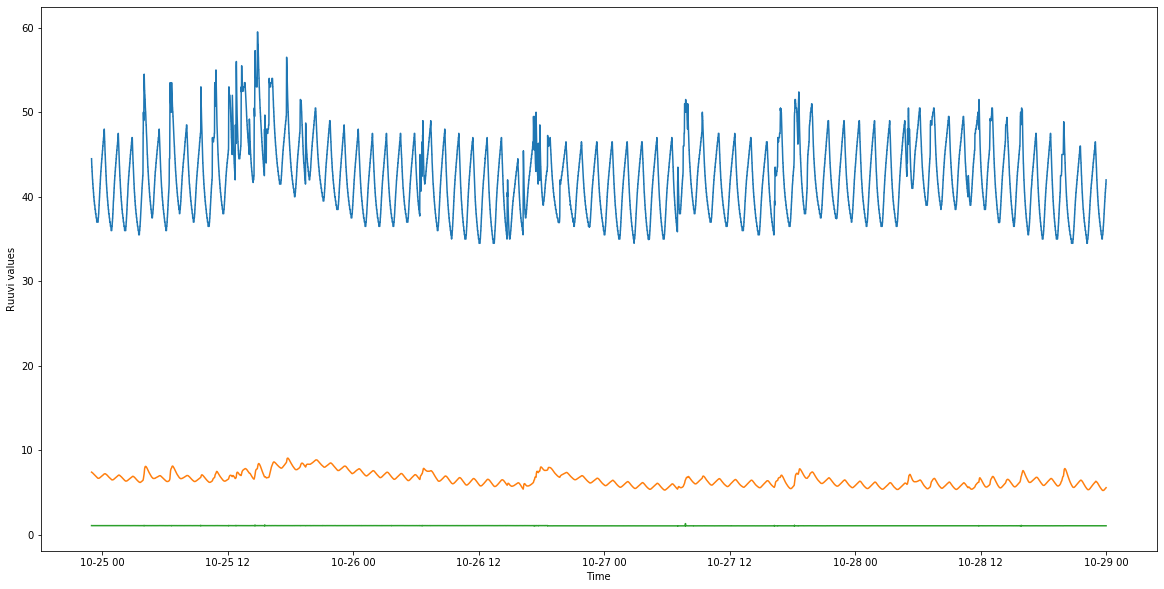

In [25]:
# Plot unscaled
plt.figure(figsize=(20, 10))
plt.xlabel("Time")
plt.ylabel("Ruuvi values")
plt.plot(df.index,df.humidity, label="Humidity")
plt.plot(df.index,df.temperature, label="Temperature")
plt.plot(df.index,df.movement, label="Acceleration")
plt.show()

#### Scale data
Lets scale data to values between 0 and 1

In [26]:
# Scale data
scaler_temperature= MinMaxScaler(feature_range=(0, 1))
data_1 = scaler_temperature.fit_transform(df.temperature.values.reshape(-1, 1))
scaler_humidity= MinMaxScaler(feature_range=(0, 1))
data_2 = scaler_humidity.fit_transform(df.humidity.values.reshape(-1, 1))
scaler_movement = MinMaxScaler(feature_range=(0, 1))
data_3 = scaler_movement.fit_transform(df.movement.values.reshape(-1, 1))

data = pd.DataFrame(data_1, columns=["temperature"])
data['humidity'] = pd.DataFrame(data_2)
data['movement'] = pd.DataFrame(data_3)

input_feature= data.iloc[:,[0,1,2]].values
input_data = input_feature

#### Plot scaled data
After scaling data is more readable and more efficient for neural network to learn weights.

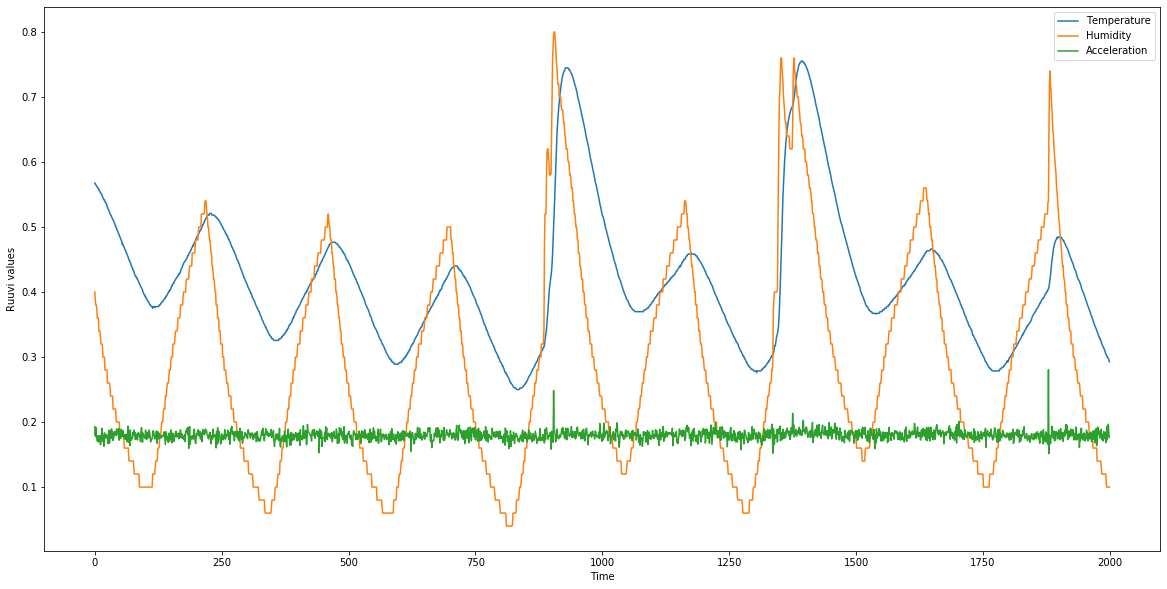

In [27]:
plt.figure(figsize=(20, 10))
plt.xlabel("Time")
plt.ylabel("Ruuvi values")
plt.plot(input_data[0:2000,0], label="Temperature")
plt.plot(input_data[0:2000,1], label="Humidity")
plt.plot(input_data[0:2000,2], label="Acceleration")
plt.legend()
plt.show()


In [ ]:
# Create datasets for training and testing
Lets split data to ration: 80% train data and 20% test data

In [30]:
def create_dataset(dataset, window_size=360):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        a = dataset[i:(i + window_size), 0]
        X.append(a)
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

window_size = 50
X, y = create_dataset(input_data, window_size)
test_split = int(len(df) * 0.8)

X_train = X[:test_split]
X_test = X[test_split:]

y_train = y[:test_split]
y_test = y[test_split:]


X_train.shape , X_test.shape, y_train.shape, y_test.shape

# Making 3D vector 
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, X_test.shape

((13968, 1, 50), (3443, 1, 50))

In [32]:
#### Create the RNN LSTM model

In [31]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 60,501
Trainable params: 60,501
Non-trainable params: 0
_________________________________________________________________


#### Fit data
Fit data using batch size 64 and 20 epochs

In [34]:
history = model.fit(X_train, y_train, batch_size=64, nb_epoch=20, validation_data=(X_test, y_test))


Train on 13968 samples, validate on 3443 samples
Epoch 1/20
13968/13968 [==============================] - 4s 275us/sample - loss: 0.0319 - val_loss: 0.0113
Epoch 2/20
13968/13968 [==============================] - 1s 71us/sample - loss: 0.0146 - val_loss: 0.0092
Epoch 3/20
13968/13968 [==============================] - 1s 65us/sample - loss: 0.0123 - val_loss: 0.0064
Epoch 4/20
13968/13968 [==============================] - 1s 72us/sample - loss: 0.0125 - val_loss: 0.0058
Epoch 5/20
13968/13968 [==============================] - 1s 82us/sample - loss: 0.0111 - val_loss: 0.0034
Epoch 6/20
13968/13968 [==============================] - 1s 75us/sample - loss: 0.0109 - val_loss: 0.0054
Epoch 7/20
13968/13968 [==============================] - 1s 73us/sample - loss: 0.0117 - val_loss: 0.0071
Epoch 8/20
13968/13968 [==============================] - 1s 72us/sample - loss: 0.0110 - val_loss: 0.0058
Epoch 9/20
13968/13968 [==============================] - 1s 64us/sample - loss: 0.0102 - val_

#### Check results
Lets plot train and test losses



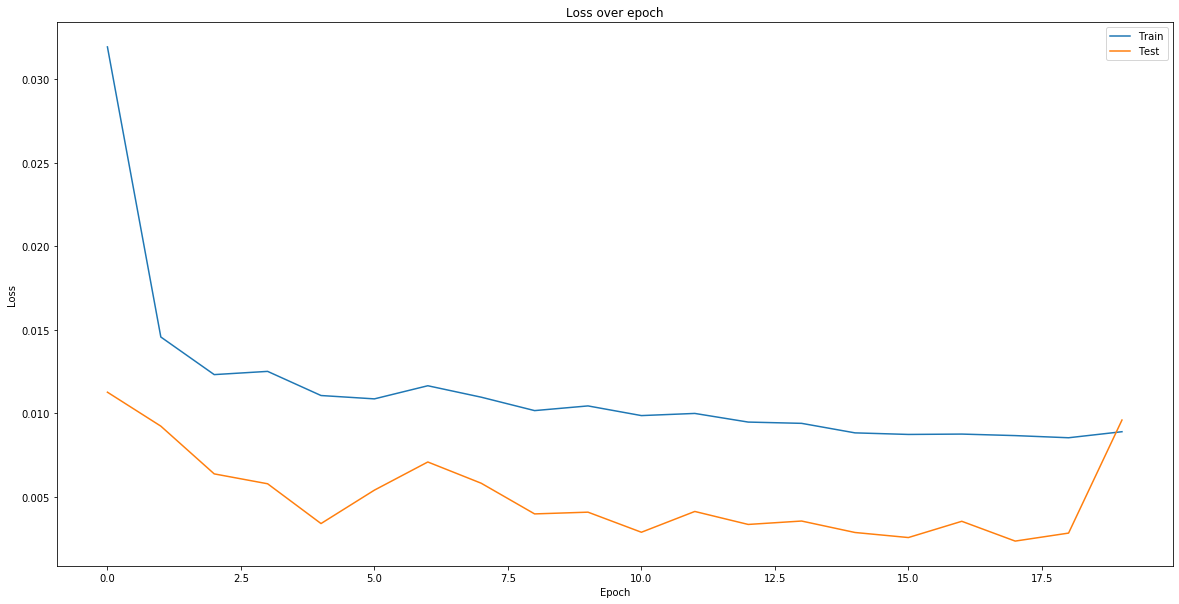

In [35]:
def plot_history(history):
    plt.figure(figsize=(20, 10))
    plt.plot(history.history["loss"],  label="Train")
    plt.plot(history.history["val_loss"], label="Test")
    plt.title("Loss over epoch")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_history(history)


Lets plot prediction on test data and compare it to actual data

Now you can see the prediction is very precise even when opening the fridge door!

Test RMSE: 0.045


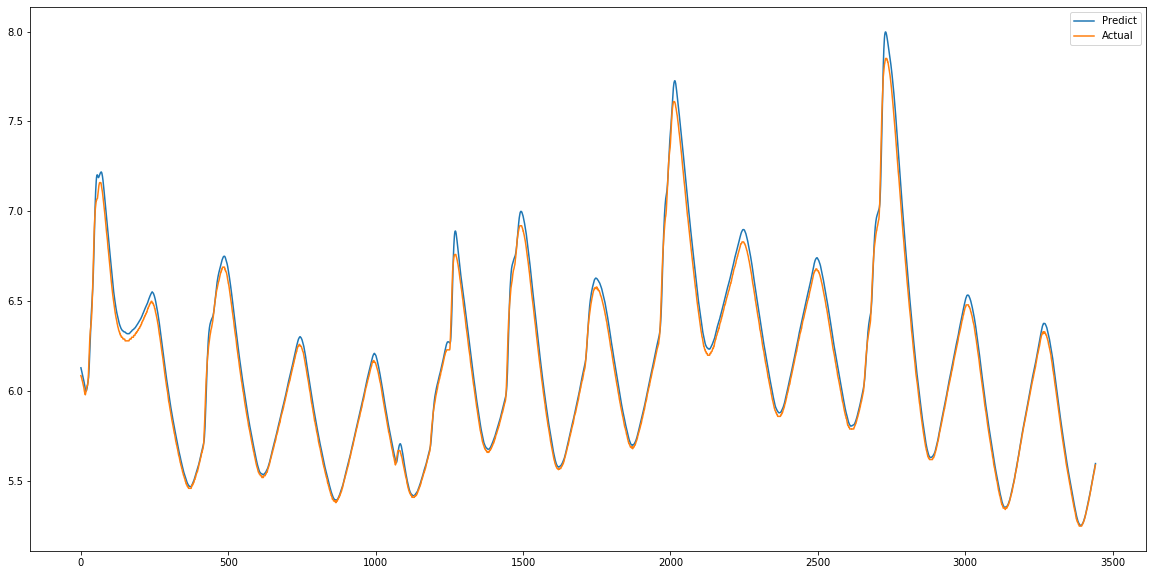

In [36]:
def plot(X_test):
    pred = model.predict(X_test)
    #pred_inverse = scaler.inverse_transform(pred.reshape(-1, 1))
    pred_inverse = scaler_temperature.inverse_transform(pred)
    y_test_inverse = scaler_temperature.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate mean_squared_error. Previosly we did MinMax scale, so apply inverse_transform to recover values
    rmse = sqrt(mean_squared_error(y_test_inverse, pred_inverse))
    print('Test RMSE: %.3f' % rmse)
    plt.figure(figsize=(20, 10))
    plt.plot(pred_inverse, label='Predict')
    plt.plot(y_test_inverse, label='Actual')
    plt.legend()
    plt.show()
    
plot(X_test)

#### References
* https://mlcourse.ai/
https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
